# Lab 6 - Information theory

This lab has a few goals designed to get you comfortable with working with python and playing with the basiscs of information theory.

Sections:
1. Entropy
2. Mutual information
3. KL divergence

## Background

For this lab we won't be working with our main library, _explorationlib_. We'll use a few standard libraries to both get more comfortable with python and to refresh the concepts of information theory discussed in class.

### **What is entropy?**

- According to Shannon's definition, the entropy $H(X)$ of a discrete random variable is: $H(X)= \sum_{x \in X} p(x) \log _2 p(x)^{-1}$.
- Here we are assuming that the discrete variable is binary, hence the use of $\log _2$
- A key aspect of the definition entropy is the 'surprise' termn, $p(x)^{-1}$. The more surprising an outcome is, the more valuable that bit of information is. We will return to this later in class.

### **Entropy between variables**

- The _joint entropy_ between two discrete random variables, $X$ and $Y$, is just an expansion of the regular concept of entropy: $H(X, Y)= \sum_{x \in X} p(x,y) \log _2 p(x,y)^{-1}$.
- Note that in here, $p(x,y)$ is the joint probability distribution between the variables.
- Expanding out from the rules of conditional probabilities (thank you Mr. Bayes), the joint entropy can be expanded as the product of the entropy of the primary variable and the conditional entropy of the two variables: $H(X,Y) = H(X) + H(Y|X)$. _Pay attention to the ordering of terms, it gets important later_.

### **Mutual information between variables**.

- Sticking with the idea of joint entropy, the _conditional entropy_ $H(X|Y)$ reflects the residual entropy of $X$ after you have knowledge about $Y$. This is expressed as: $H(X|Y)=H(X)-I(X;Y)$.
- We call this second term, $I(X;Y)$ the _mutual information_ between $X$ and $Y$. It is the information provided by Y about X. If you were in statistics and working with continuous variables, this would be the correlation (or covariance).
- We can rewrite the equation above as $I(X;Y) = H(X) - H(X|Y) = \sum_{x \in X, y \in Y} p(x,y) \log _2 \frac{p(x,y)}{p(x)p(y)}$

### **Kullback-Leibler (KL) divergence**.

- Often referred to as relative entropy, this is a measure of how one probability distribution diverges from a second, reference probability distribution. It quantifies the amount of information lost when approximating one distribution with another.

- Consider $P(X)$ and $Q(X)$ to be two probability distribtions of a random variable. In our example, spike trains from two neurons.

- The KL divergence of $P$ and $Q$, $D_{KL}(P||Q)$, is defined as

$$D_{KL}(P||Q)=\Sigma_{x \in X} p(x)\log_2 (\frac{p(x)}{q(x)})$$

- Essentially $D_{KL}(P||Q)$ is a measure of the distance between two distributions

## Section 0 - Setup

For today's lab we'll start simple. All we need is _numpy_ and _matplotlib_ (for plotting)

In [ ]:
# Import the general libraries we will be using
import numpy as np
import matplotlib.pyplot as plt

## Section 1 - Entropy

- For this section we will simulate two cells, a presynaptic and postsynaptic cell. The data will consist of spikes. We will vary the degree of dependency between the neurons and look at their relative entropies.
- One way to achieve this is to use a Poisson process to simulate the neurons. Here, the firing of each neuron at each time step is modeled as a binary event that occurs with some probability. The influence of the first neuron on the second is represented by increasing the firing probability of the second neuron when the first one fires.

In [ ]:
def simulate_neuron_spikes(n_samples, base_firing_prob, influence, noise_level, neuron1=None):
    """
    Simulate the spiking of a neuron.

    If neuron1 is not None, then this neuron is influenced by neuron1.
    """
    spikes = np.zeros(n_samples)

    for i in range(n_samples):
        firing_prob = base_firing_prob

        if neuron1 is not None and neuron1[i] == 1:
            firing_prob += influence

        firing_prob += noise_level * np.random.randn()

        if np.random.uniform(low=0.0, high=1.0) < firing_prob:
            spikes[i] = 1

    return spikes



In [ ]:
# Time and rates
total_time_sec = 5
sampling_rate_hz = 1000
n_samples = total_time_sec * sampling_rate_hz

# Probabilities
base_firing_prob = 0.02
influence = 0.3
noise_level = 0.01

# Simulate the two neurons
neuron1 = simulate_neuron_spikes(n_samples, base_firing_prob, 0, noise_level)
neuron2 = simulate_neuron_spikes(n_samples, base_firing_prob, influence, noise_level, neuron1)

print("Neuron 1 spike train:", neuron1)
print("Neuron 2 spike train:", neuron2)

Neuron 1 spike train: [0. 0. 0. ... 0. 0. 0.]
Neuron 2 spike train: [0. 0. 0. ... 0. 0. 0.]


What we have created are two binary vectors, _neuron1_ and _neuron2_, that represent the spike trains of two neurons over 5 seconds at a 1 kHz sampling rate.

Each time step is a binary event where 1 represents a spike and 0 represents no spike. The base firing probability is 2%, but this is modified by two factors: the influence of the first neuron on the second, and some independent noise.

The _influence_ parameter controls how much the first neuron affects the second: whenever the first neuron fires, the firing probability of the second neuron is increased by the influence factor. The _noise level_ parameter controls the amount of independent noise in the firing probabilities. This noise is modeled as Gaussian noise and is independent for each neuron and each time step.

### Visualizing our two neurons

We can use a raster plot to visualize the spike times of our neurons. For this we will use matplotlib.

In a raster plot, each row corresponds to a different repetition of the experiment (a different neuron in this case), and the x-axis represents time. Each small vertical line (marker) represents a spike.

In [ ]:
def plot_spikes(neuron1, neuron2, sampling_rate_hz):
    """
    Plot the spikes of the two neurons as a raster plot.
    """
    time_points = np.arange(len(neuron1)) / sampling_rate_hz

    fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True, sharey=True)

    # Neuron 1
    ax[0].eventplot(time_points[neuron1 == 1], color='black')
    ax[0].set_title("Neuron 1")
    ax[0].set_ylabel("Spikes")

    # Neuron 2
    ax[1].eventplot(time_points[neuron2 == 1], color='black')
    ax[1].set_title("Neuron 2")
    ax[1].set_ylabel("Spikes")
    ax[1].set_xlabel("Time (sec)")

    plt.tight_layout()
    plt.show()


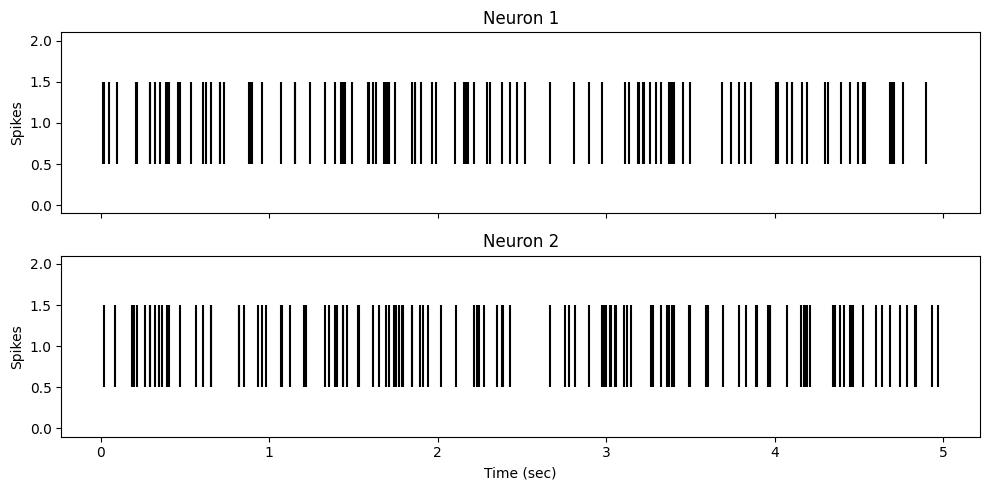

In [ ]:
# Run the plotting function
plot_spikes(neuron1, neuron2, sampling_rate_hz)

Let's now calculate the entropy of each neuron. For this we will use a simple function that follows the equations for entropy in the Background and the reading.

In [ ]:
def calculate_entropy(neuron):
    """
    Calculate the entropy of the spike train of a neuron.
    """
    # Count the number of 0s and 1s in the array
    unique, counts = np.unique(neuron, return_counts=True)
    probs = counts / len(neuron)

    # Calculate the entropy
    entropy = -np.sum(probs * np.log2(probs))
    return entropy

Now let's see how our neurons are doing.

In [ ]:
# Calculate and print the entropies
entropy_neuron1 = calculate_entropy(neuron1)
entropy_neuron2 = calculate_entropy(neuron2)

print(f"Entropy of Neuron 1: {entropy_neuron1}")
print(f"Entropy of Neuron 2: {entropy_neuron2}")


Entropy of Neuron 1: 0.1503322286475233
Entropy of Neuron 2: 0.17182160114151904


---
### Question 1.1

Increase the baseline firing rate parameter, *base_firing_prob*, by a factor of 10 to 0.2. What happens to the entropies of the neurons? Explain why this effect may or may not occur.

__Answer:__

When base_firing_prob = 0.02...

Entropy of Neuron 1: 0.15904899712679427

Entropy of Neuron 2: 0.13578841288558574

When base_firing_prob = 0.2...

Entropy of Neuron 1: 0.7146694002159704

Entropy of Neuron 2: 0.7572351698340638

The base firing probability controls how likely it is for a neuron to spike at each time step. Thus, when this value is increased, the neuron is more likely to spike. The distribuation of 1s (spikes) and 0s (no spikes) becomes more balanced. Since the neuron now fires more often, the uncertainity about whether it will fire at a given time step increase, which leads to higher entropy.

---
### Question 1.2

Put the baseline firing rate parameter back to 0.02. Increase the influence parameter, from neuron 1 to neuron 2, by a factor of 10 to 0.3. What happens to the entropies of the neurons? Explain why this effect may or may not occur.

__Answer:__

When influence = 0.03...

Entropy of Neuron 1: 0.15904899712679427

Entropy of Neuron 2: 0.13578841288558574

When influence = 0.3...

Entropy of Neuron 1: 0.1503322286475233

Entropy of Neuron 2: 0.17182160114151904

By increasing the influence parameter from neuron 1 to neuron 2 to 0.3, the firing neuron 2 will become more dependent on neuron 1's activity. However, since neuron2 isn't perfectly matching neuron1 (due to noise), there's more uncertainity about whether it will fire at a given time step. This increases entropy because it is less certain whether neuron2 will fire based on neuron1's input alone. However, neuron 1's entropy remained relatively unchanged, as its firing rate is still determined by its baseline probability.

## Section 2 - Mutual information

We have our two happy little neurons firing. We've played with the parameters to see how it impacts their relative entropy. Now let's go back to the original parameter settings and see about estimating the mutual information between our neurons.

Recall that to estimate the mutual information, we need to estimate the conditional entropy for $X$ on $Y$. For binary variables things are a bit easier because $H(X|Y) = H(Y) - H(X,Y)$. Which means we only need to get both independnet entropies and the joint entropy. This leaves us with this simple and beautiful equation: $I(X; Y) = H(X) + H(Y) - H(X, Y)$.

We can easily write a function to do this. First we start with esimating the joint entropy of the two variables.

$$ H(X,Y) = -\Sigma_{x,y}P(X=x,Y=y)\log_2 P(X=x, Y=y) $$

In [ ]:
def calculate_joint_entropy(neuron1, neuron2):
    # Calculate joint probability distribution
    joint_prob, _, _ = np.histogram2d(neuron1, neuron2, bins=2, range=[[0, 1], [0, 1]])
    joint_prob /= len(neuron1)

    # Calculate joint entropy
    joint_entropy = -np.sum(joint_prob * np.log2(joint_prob + np.finfo(float).eps))

    return joint_entropy

Let's take a moment to take a look at this central estimate of the joint firing probabilities. We'll pull this out of the function and probe here.

In [ ]:
joint_prob, _, _ = np.histogram2d(neuron1, neuron2, bins=2, range=[[0, 1], [0, 1]])
joint_prob /= len(neuron1)
print(f"{joint_prob}")

[[0.961  0.0176]
 [0.0146 0.0068]]


Most of the time, both neurons are 0 (upper left value). A small percentage of the time one neuron fires when the other does not (off diagonal entries). Finally, a small percentage of the time both neurons fire together (lower right).

Now we can calculate the full mutual information by subtracting this joint entropy from the relative entropy of the two variables.

In [ ]:
def calculate_mutual_information(neuron1, neuron2):
    """
    Calculate the mutual information between the spike trains of two neurons.
    """
    entropy_neuron1 = calculate_entropy(neuron1)
    entropy_neuron2 = calculate_entropy(neuron2)
    joint_entropy = calculate_joint_entropy(neuron1, neuron2)

    # Use the formula for mutual information
    mutual_information = entropy_neuron1 + entropy_neuron2 - joint_entropy

    return mutual_information


So let's see what the mutal information is when we re-simulate our neurons back at the original parameter settings.

In [ ]:
# Time and rates
total_time_sec = 5
sampling_rate_hz = 1000
n_samples = total_time_sec * sampling_rate_hz

# Probabilities
base_firing_prob = 0.02
influence = 0.3
noise_level = 0.01

# Simulate the two neurons
neuron1 = simulate_neuron_spikes(n_samples, base_firing_prob, 0, noise_level)
neuron2 = simulate_neuron_spikes(n_samples, base_firing_prob, influence, noise_level, neuron1)

# Calculate and print the mutual information
mutual_information = calculate_mutual_information(neuron1, neuron2)
print(f"Mutual Information: {mutual_information}")

Mutual Information: 0.01670888718161212


This reflects the mutual dependence between the two neurons. You can probably guess what questions we will ask about this.

---
### Question 2.1

Increase the baseline firing rate parameter, *base_firing_prob*, by a factor of 10 to 0.2. What happens to the mutual information of the neurons? Explain why this effect may or may not occur.

__Answer:__

When base_firing_prob = 0.02...

Mutual Information: 0.0005708016749340628

When base_firing_prob = 0.2...

Mutual Information: 0.00012062185929662128

When the baseline firing probability is increased to 0.2, both neurons are more likely to fire independently. This increase in independent spiking activity reduces the mututal information becaues mutual information quantifies the dependency between the two neurons. As the neurons are now firing independently, the shared information between them is reduced. Therefore, the mutual information decreased compared to the case where the firing probabilities were lower and neuron 2's firing was more dependent on neuron 1.

---
### Question 2.2

Put the baseline firing rate parameter back to 0.02. Increase the influence parameter, from neuron 1 to neuron 2, by a factor of 10 to 0.3. What happens to the mutual information of the neurons? Explain why this effect may or may not occur.

__Answer:__

When influence = 0.03...

Mutual Information: 0.0005078424071291998

When influence = 0.3...

Mutual Information: 0.015166075734763584

When the influence parameter increases to 0.3, neuron 2 becomes more dependent on neuron 1, meaning neuron 2 is more likely to fire when neuron 1 fires. This increased dependence leads to higher mutual information between the two neurons because mutual information measures the extent to which one neuron provides information about the other. Since neuron 2's firing is now more closely tied to neruon 1's firing, their mutual information will increase.

---
### Question 2.3

Take the last set of simulations that you ran (with the influence set at 0.3) and switch the order of the neurons in the calculation of mutual information. What does or does not happen to the mutual information estimate? Why?

__Answer:__

When mutual_information = calculate_mutual_information(neuron2, neuron1)...

Mutual Information: 0.018507956355392874

When mutual_information = calculate_mutual_information(neuron1, neuron2)...

Mutual Information: 0.01648512192903906

The mutual information estimate remains relatively unchanged when switching the order of neurons in the calculation. This is because mutual information is a symmetric measure; it quantifies the shared information between two variables, regardless of the order in which they are entered into the calculation. Therefore, switching the order of neuron 1 and neuron 2 should yeild the same mutual information value.

## Section 3 - KL divergence

We can now move on to our information measure of interest, the KL divergence, $D_{KL}(P||Q)$. Let's start by setting up our neurons so that the first, presynaptic neuron has a strong influence on the spiking probability of the second, postsynaptic neuron.

For this we will make a strong synaptic connection by changing the *influence* parameter to 0.99, which means that when neuron1 spikes, neuron2's firing probability increases by 99%.

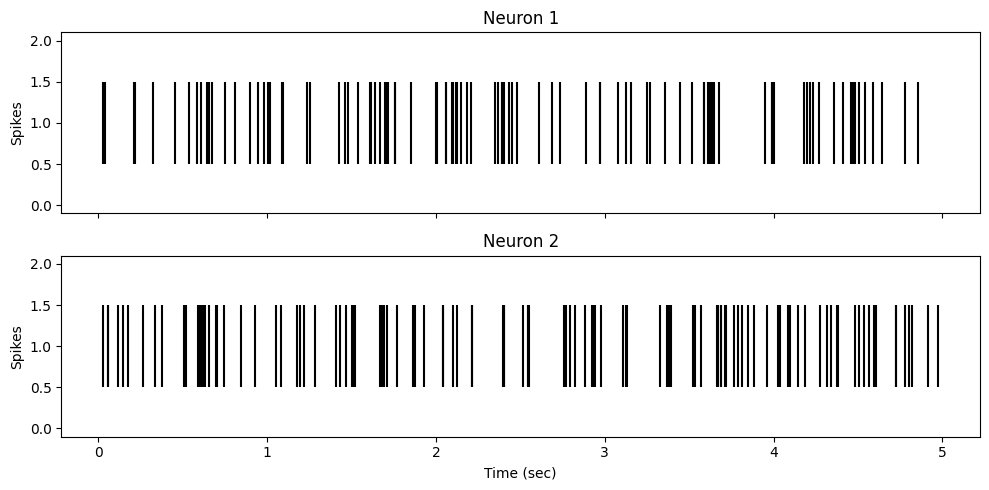

In [ ]:
# Time and rates
total_time_sec = 5
sampling_rate_hz = 1000
n_samples = total_time_sec * sampling_rate_hz

# Probabilities
base_firing_prob = 0.02
influence = 0.03
noise_level = 0.01

# Simulate the two neurons
neuron1 = simulate_neuron_spikes(n_samples, base_firing_prob, 0, noise_level)
neuron2 = simulate_neuron_spikes(n_samples, base_firing_prob, influence, noise_level, neuron1)

# Plot
plot_spikes(neuron1, neuron2, sampling_rate_hz)

Now let's write a simple function to calculate the KL divergence.

In [ ]:
def calculate_kl_divergence(neuron1, neuron2):
    # Calculate probability distributions
    unique, counts = np.unique(neuron1, return_counts=True)
    p1 = counts / len(neuron1)

    unique, counts = np.unique(neuron2, return_counts=True)
    p2 = counts / len(neuron2)

    # Avoid division by zero and log(0) by adding a small constant
    epsilon = np.finfo(float).eps
    p1 = np.clip(p1, epsilon, 1)
    p2 = np.clip(p2, epsilon, 1)

    # Calculate KL divergence
    kl_div = np.sum(p1 * np.log2(p1 / p2))

    return kl_div

Using the spiking data above, we get the following

In [ ]:
kl_div_value = calculate_kl_divergence(neuron1, neuron2)
print(f"KL Divergence: {kl_div_value}")


KL Divergence: 0.00030752586093101


Just to prove to you that KL divergence measures similarity in distributions, let's make two completely independent neurons and look at their KL divergence score.

In [ ]:
# Simulate the two neurons
neuron3 = simulate_neuron_spikes(n_samples, base_firing_prob, 0, noise_level)

kl_div_value = calculate_kl_divergence(neuron1, neuron3)
print(f"KL Divergence: {kl_div_value}")

KL Divergence: 2.4686054953062392e-05


---
### Question 3.1

What does it mean that the KL diverence is higher for our connected neurons (neuron1, neuron2) than our unconnected neurons (neuron1, neuron3)

__Answer:__

Connected neurons (neuron1, neuron2) -

KL Divergence: 0.00877585483669327

Unconnected neurons (neuron1, neuron3) -

KL Divergence: 0.0012159672940570722

The higher KL divergence for the connected neurons means that their firing patterns are more dissimiliar (less similiar) compared to the unnconnected neurons. This is because neuron2's firing is influence by neuron1, which changes neuron2's firing distribution. In constrast, neuron1 and neuron3, being unconnected and independent, have very similiar firing distribuations, leading to a lower KL divergence. Thus, a higher KL divergence reflects a greater dissimiliarity due to the influence of neuron1 on neuron2.

---
### Question 3.2

Go back to our connected neurons (neuron1 & neuron2) and change the *influence* parameter back to 0.03. How does the KL divergence change? Explain why this effect may or may not occur.

__Answer:__

When influence = 0.99...

KL Divergence: 0.00877585483669327

When influence = 0.03...

KL Divergence: 0.000552400520925327

When the influence parameter is reduced to 0.03, neuron2 becomes less dependent on neuron1. As a result, their firing distribuations become more independent and similiar, which reduces the KL divergence. This happens because neuron2's firing pattern now resembles neuron1's baseline firing pattern more closely and becomes more similiar to its orginal independent firing pattern, decreasing the difference between their distributions. Thus, the KL divergence will decrease as the influence decreases.

## Section 4 - Putting it together

Now let's simulate a set of experiments were we systematically increase the *influence* parameter and see how our three measures change.

In [ ]:
# Time and rates
total_time_sec = 5
sampling_rate_hz = 1000
n_samples = total_time_sec * sampling_rate_hz

# Probabilities
base_firing_prob = 0.02
noise_level = 0.01

# Influence parameters
influences = [0.01, 0.1, 0.5, 0.75, 0.99]

# For plotting
names = influences

e1 = []
e2 = []
mi = []
kl = []

for influence in influences:
  neuron1 = simulate_neuron_spikes(n_samples, base_firing_prob, 0, noise_level)
  neuron2 = simulate_neuron_spikes(n_samples, base_firing_prob, influence, noise_level, neuron1)

  e1.append(calculate_entropy(neuron1))
  e2.append(calculate_entropy(neuron2))
  mi.append(calculate_mutual_information(neuron2, neuron1))
  kl.append(calculate_kl_divergence(neuron2, neuron1))


First let's look at the relative entropies of the two neurons.

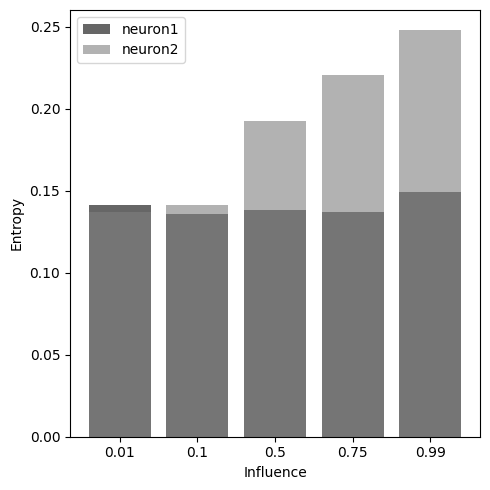

In [ ]:
# Now let's plot the entropies first
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], e1, color="black", alpha=0.6, label="neuron1")
plt.bar([str(n) for n in names], e2, color="grey", alpha=0.6, label="neuron2")
plt.ylabel("Entropy")
plt.xlabel("Influence")
plt.tight_layout()
plt.legend()

---
### Question 4.1

What do you notice about the relative entropies of the two neurons?

__Answer:__

Neuron1's entropy remains relatively stable as the influence parameter increases, while neuron2's entropy increases significantly as the influence parameter increases.


Next let's look at the mutual information.

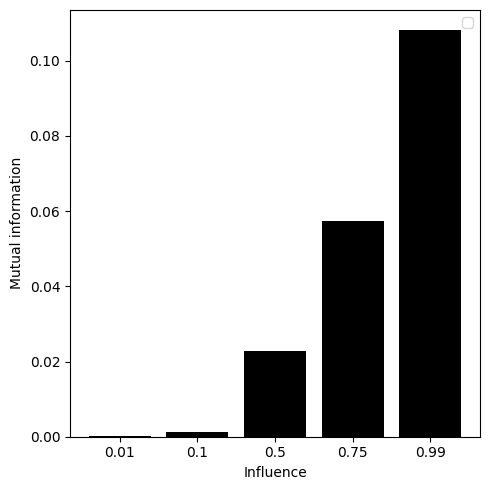

In [ ]:
# Now let's plot the mutual information
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], mi, color="black")
plt.ylabel("Mutual information")
plt.xlabel("Influence")
plt.tight_layout()
plt.legend()

---
### Question 4.2

What does the mutual information do as you increase the presynaptic influence on the postsynaptic cell? Why does this occur?

__Answer:__

As the presynaptic influence on the postsynaptic cell increases, the mutual information also increases. This is becase the firing patterns of the two neurons become more correlated; as neuron2 becomes more dependent on neuron1, the activity of neuron1 provides more information about neuron2's behavior. Therefore, their shared information (mutual information) increases. As the influence approaches 1, neuron2's firing is almost entirely determined by neuron 1, leading to the highest mutual information.

Finally, let's look at the KL divergence.

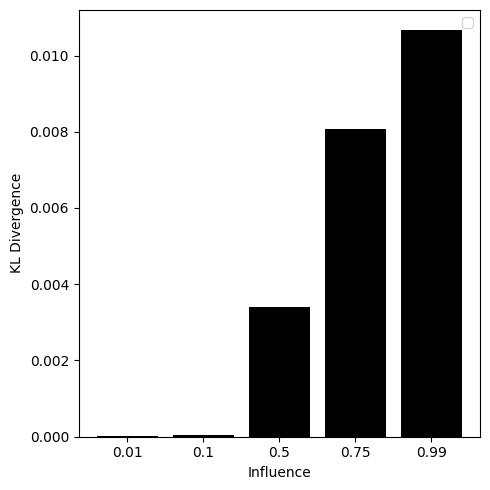

In [ ]:
# Finally KL divergence
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], kl, color="black")
plt.ylabel("KL Divergence")
plt.xlabel("Influence")
plt.tight_layout()
plt.legend()

---
### Question 4.3

What does the KL divergence do as you increase the presynaptic influence on the postsynaptic cell? Why does this occur?

__Answer:__

As the presynaptic influence of the postsynaptic cell increases, the KL divergence also increases. This occurs because neuron2's firing pattern, though becoming more influenced by neuron1, deviates more from neuron1's original independent baseline. Neuron2's pattern becomes more dependent on neuron1 in a way that makes it deviate more from neuron1's original independent firing pattern.

---
### Question 4.4

Put all three results together and in simple English, explain what is happening the properties of both neurons as you increase the influence parameter.

__Answer:__

As influence grows, neuron2 becomes more controlled by neuron1, leading to more shared information between them (higher mutual information), but also more divergence from neuron1's orginal independent firing pattern (higher KL diveregence). With increased influence, neuron2 fires more often and in a less predictable pattern due to the mixed influence from neuron1 and its own inhernet noise, which increases its entropy compared to its simple, low-probability baseline behavior.


---
**IMPORTANT** Did you collaborate with anyone on this assignment, or use LLMs like ChatGPT? If so, list their names here.
> *Write Name(s) here*